In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
from Preprocessor import Preprocessor
# from Registerer import Registerer
import SimpleITK as sitk
import ndreg

/usr/local/lib/python2.7/dist-packages/tifffile/tifffile.py:306: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


In [8]:
import ndreg
import SimpleITK as sitk


class Registerer:

    def __init__(self, img, atlas):
        if type(img) != sitk.SimpleITK.Image:
            raise Exception("Please convert your image into a SimpleITK Image")
        if type(atlas) != sitk.SimpleITK.Image:
            raise Exception("Please convert your image into a SimpleITK Image")
        else:
            self.img = img
            self.atlas = atlas
            self.affine = []
            self.atlas_affine = None
            self.fieldComposite = None
            self.invFieldComposite = None

    def register_affine(self, inOrient, refOrient, spacing, iterations=2000.0, resolutions=8.0):
        img_reoriented = ndreg.imgReorient(self.img, inOrient, refOrient)
        atlas_ds = sitk.Clamp(ndreg.imgResample(self.atlas, spacing), upperBound=ndreg.imgPercentile(self.atlas, 0.99))
        img_ds = sitk.Clamp(ndreg.imgResample(img_reoriented, spacing), upperBound=ndreg.imgPercentile(img_reoriented, 0.99))
        print(atlas_ds.GetSize())
        print(img_ds.GetSize())
        print(atlas_ds.GetSpacing())
        print(img_ds.GetSpacing())
        fixedImage = img_ds
        movingImage = atlas_ds
        ndreg.imgShow(img_ds)
        ndreg.imgShow(atlas_ds)
        # set parameters
        affineParameterMap = sitk.GetDefaultParameterMap('affine')
        affineParameterMap['Metric'] = ['AdvancedMeanSquares']
        affineParameterMap['MaximumNumberOfIterations'] = ['{}'.format(iterations)]
        affineParameterMap['Optimizer'] = ['StandardGradientDescent']
        affineParameterMap['NumberOfResolutions'] = '{}'.format(resolutions)  
        
        elastixImageFilter = sitk.ElastixImageFilter()
        elastixImageFilter.SetFixedImage(fixedImage)
        elastixImageFilter.SetMovingImage(movingImage)
        elastixImageFilter.SetParameterMap(affineParameterMap)
        elastixImageFilter.Execute()
        self.atlas_affine = elastixImageFilter.GetResultImage()
        transformParameterMap = elastixImageFilter.GetTransformParameterMap()[0] 
        self.affine = [float(i) for i in transformParameterMap['TransformParameters']]
        return self.atlas_affine
        
    def register_lddmm(self, affine_img, target_img, alphaList=[0.05], scaleList=[0.0625, 0.125, 0.25],
            epsilonList=1e-7, sigma=None, useMI=False, iterations=200, verbose=True):
        if sigma == None:
            sigma = (0.1/inImg_ds.GetNumberOfPixels())
        (field, invField) = ndreg.imgMetamorphosisComposite(affine_img, target_img, alphaList=alphaList,
                                              scaleList = scaleList, epsilonList=epsilonList, sigma=sigma,
                                              useMI=useMI, iterations=iterations, verbose=verbose)
        affineField = ndreg.affineToField(self.affine, field.GetSize(), field.GetSpacing())
        self.fieldComposite = ndreg.fieldApplyField(field, affineField)

        invAffineField = ndreg.affineToField(affineInverse(self.affine), invField.GetSize(), invField.GetSpacing())
        self.invFieldComposite = ndreg.fieldApplyField(invAffineField, invField)
       
        refImg_lddmm = ndreg.imgApplyField(affine_img, self.fieldComposite, size=inImgReoriented.GetSize(), spacing=inImgReoriented.GetSpacing())
        

### Step 1: Load data

In [9]:
img = ndreg.imgRead('../forVikram/ailey-dev_thy1eyfp_control_9_upload20170919_ch1_res3.img')
atlas = ndreg.imgRead('../forVikram/ara3_average_res2.img')

### Step 2: initialize Preprocessor class

In [10]:
preprocessor = Preprocessor(img)

### Step 3: remove streaks

In [11]:
new_img = preprocessor.remove_streaks()

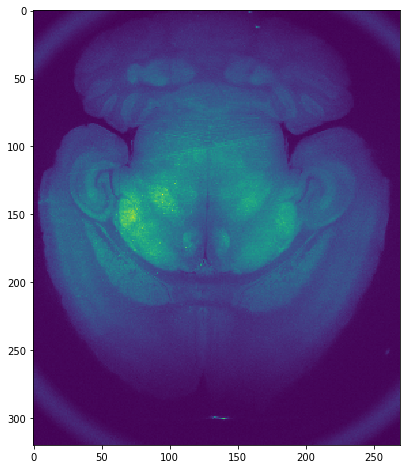

In [12]:
plt.imshow(preprocessor.img_np[80,:,:])
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


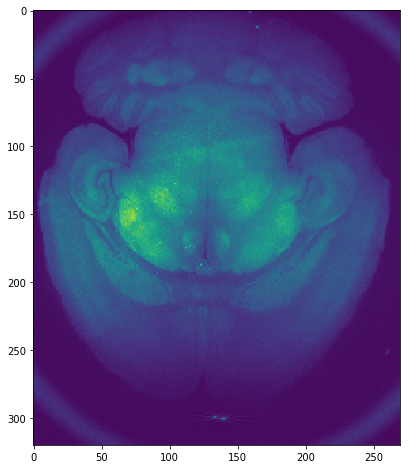

In [8]:
plt.imshow(new_img[80,:,:].astype('float'))
plt.show()

### Step 4: Remove circle

In [9]:
img_no_circle = preprocessor.remove_circle()

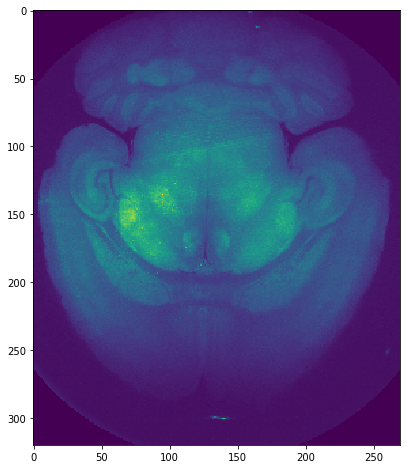

In [10]:
plt.imshow(img_no_circle[80,:,:])
plt.show()

### Step 5: create mask

In [6]:
mask = preprocessor.create_mask()

KeyboardInterrupt: 

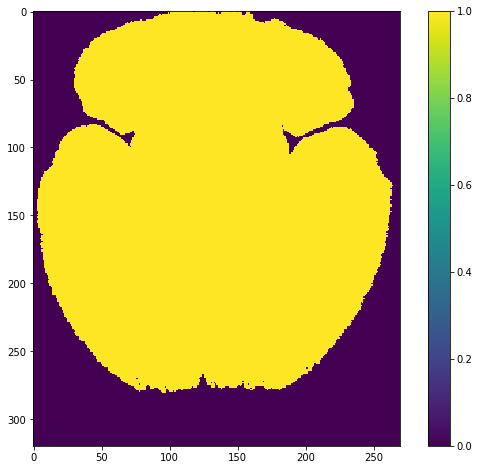

In [9]:
plt.imshow(mask[80,:,:])
plt.colorbar()
plt.show()

### Step 5: Correct Bias field

In [15]:
img_bias_corrected = preprocessor.correct_bias_field(scale=0.1)

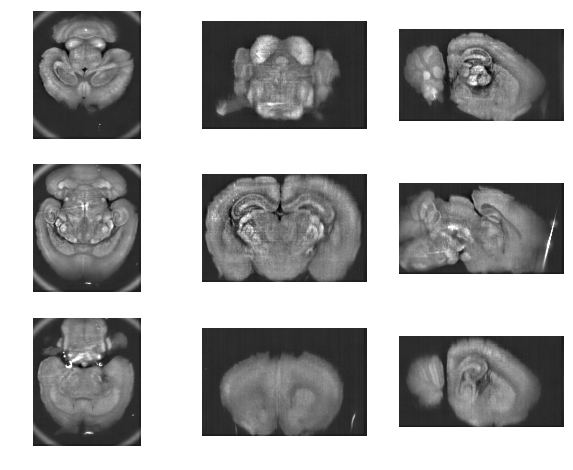

In [16]:
ndreg.imgShow(img_bias_corrected, vmax=1000)

## Registration

In [13]:
registerer = Registerer(img, atlas)

### Perform affine registration

(114, 80, 132)
(112, 74, 133)
(0.1, 0.1, 0.1)
(0.1, 0.1, 0.1)


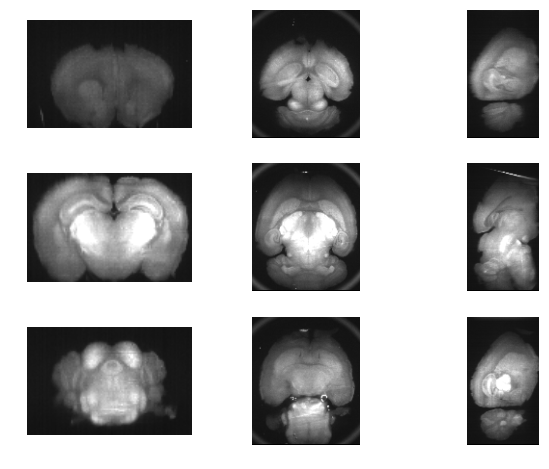

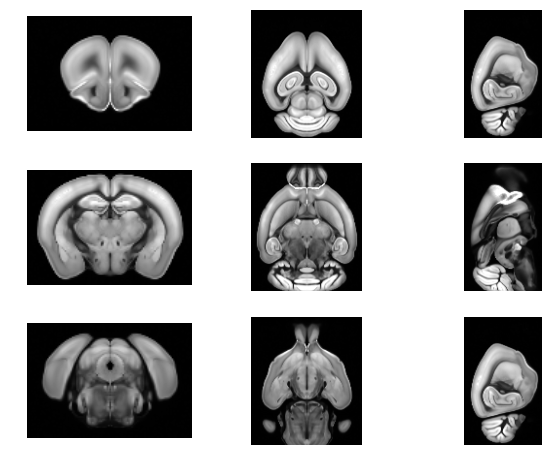

RuntimeError: Exception thrown in SimpleITK ElastixImageFilter_Execute: /SimpleElastix/Code/Elastix/src/sitkElastixImageFilterImpl.cxx:259:
sitk::ERROR: 
itk::ExceptionObject (0x5aed330)
Location: "unknown" 
File: /build/Elastix/Core/Main/elxElastixFilter.hxx
Line: 248
Description: itk::ERROR: Self(0x5ba3030): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



In [14]:
registerer.register_affine("RPS", "LSA", [0.100, 0.100, 0.100], iterations=1000.0, resolutions=4.0)

In [13]:
atlas.GetSpacing()

(0.03999999910593033, 0.03999999910593033, 0.03999999910593033)

### Perform LDDMM registration

### Evaluate registration with fiducials